# Relative Overgeneralisation environment

In [34]:
import numpy as np
import random

class RelOvergenEnv:

    def __init__(self, state_dim, 
                 optim_reward=8, optim_diff_coeff=25, 
                 suboptim_reward=0, suboptim_diff_coeff=0.125):
        self.obs_dim = state_dim
        self.act_dim = 2

        self.state_dim = state_dim
        self.unit = 10.0 / state_dim
        self.states = list(np.arange(0.0, 10.0, self.unit))

        self.agents_pos = [0, 0]

        self.optimal_state = [
            int(state_dim / 5) * self.unit, 
            int(state_dim / 6) * self.unit]
        self.suboptimal_state = [
            10.0 - self.optimal_state[0], 
            10.0 - self.optimal_state[1]]
        
        self.optim_reward = optim_reward
        self.optim_diff_coeff = optim_diff_coeff
        self.suboptim_reward = suboptim_reward
        self.suboptim_diff_coeff = suboptim_diff_coeff
        
        self.max_steps = state_dim
        self.current_step = 0

    def get_obs(self):
        return [
            np.eye(self.state_dim)[self.agents_pos[0]],
            np.eye(self.state_dim)[self.agents_pos[1]]
        ]

    def reset(self):
        for a_i in range(2):
            self.agents_pos[a_i] = random.randint(0, self.state_dim - 1)
        self.current_step = 0
        return self.get_obs()

    def compute_reward(self):
        opti = self.optim_reward - self.optim_diff_coeff * (
            (self.states[self.agents_pos[0]] - self.optimal_state[0]) ** 2 + 
            (self.states[self.agents_pos[1]] - self.optimal_state[1]) ** 2)
        subopti = self.suboptim_reward - self.suboptim_diff_coeff * (
            (self.states[self.agents_pos[0]] - self.suboptimal_state[0]) ** 2 + 
            (self.states[self.agents_pos[1]] - self.suboptimal_state[1]) ** 2)
        return max(opti, subopti)

    def step(self, actions):
        for a_i in range(2):
            self.agents_pos[a_i] += int(actions[a_i][0])
            self.agents_pos[a_i] -= int(actions[a_i][1])
            if self.agents_pos[a_i] < 0:
                self.agents_pos[a_i] = 0
            elif self.agents_pos[a_i] >= self.state_dim:
                self.agents_pos[a_i] = self.state_dim - 1
        next_states = self.get_obs()

        reward = self.compute_reward()
        rewards =[reward, reward]
        
        self.current_step += 1
        done = float(self.current_step >= self.max_steps)
        dones = [done, done]
        
        return next_states, rewards, dones, None
    
    def close(self):
        pass

In [18]:
env = RelOvergenEnv(50)

In [19]:
env.reset()
print(env.agents_pos)
print(env.get_obs())
print(env.compute_reward())

[46, 49]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])]
-0.7250000000000009


## Plotting the reward function

In [4]:
def get_reward_function(env):
    reward = np.zeros((env.state_dim, env.state_dim))
    for i in range(env.state_dim):
        for j in range(env.state_dim):
            env.agents_pos = [i, j]
            reward[i, j] = env.compute_reward()
    return reward

<AxesSubplot:>

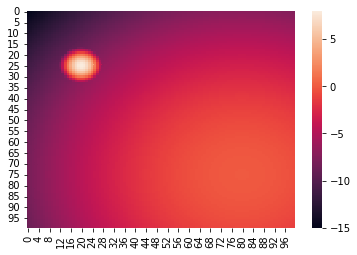

In [30]:
import seaborn as sns

env = RelOvergenEnv(100, 8, 25, 0, 0.125)
reward = get_reward_function(env)
sns.heatmap(reward)

<AxesSubplot:>

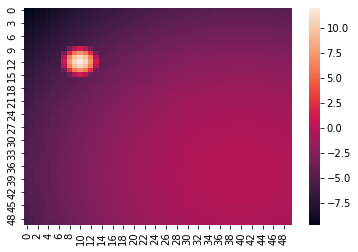

In [32]:
env = RelOvergenEnv(50, 12, 30, 0, 0.08)
reward = get_reward_function(env)
sns.heatmap(reward)

<AxesSubplot:>

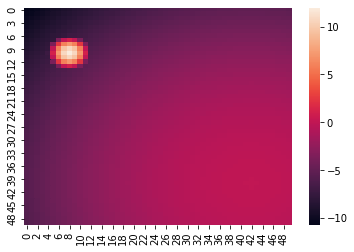

In [41]:
env = RelOvergenEnv(50, 12, 30, 0, 0.08)
reward = get_reward_function(env)
sns.heatmap(reward)

In [42]:
env.reset()

[array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

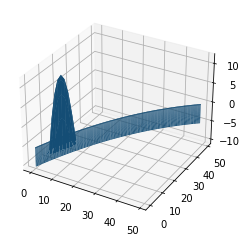

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot_surface(list(range(50)), list(range(50)), reward)

## Plotting learnt Q-values

In [94]:
import torch

def get_q_tot(obs, model):
    init_last_actions, init_hidden_states = model.get_init_model_inputs()
    values = []
    for a_i in range(len(obs)):
        q_values, _ = model.agents[a_i].get_q_values(
            obs[a_i], 
            init_last_actions[a_i],
            init_hidden_states[a_i])
        values.append(float(q_values.max()))
    values = torch.Tensor(values).view(1, 1, -1)
    state = torch.cat(obs, dim=-1).unsqueeze(0)
    q_tot = model.mixer(values, state)
    return float(q_tot)

def get_q_function(model):
    value_fn = np.zeros((model.obs_dim, model.obs_dim))
    for i in range(model.obs_dim):
        for j in range(model.obs_dim):
            obs = [
                torch.Tensor([np.eye(model.obs_dim)[i]]),
                torch.Tensor([np.eye(model.obs_dim)[j]])
            ]
            value_fn[i, j] = get_q_tot(obs, model)
    return value_fn

<AxesSubplot:>

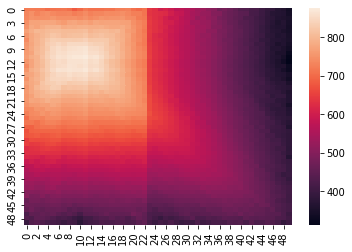

In [95]:
from model.modules.qmix_noveld import QMIX_MANovelD

model = QMIX_MANovelD.init_from_save("../../models/rel_overgen/qmix_manoveld_fo/run8/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

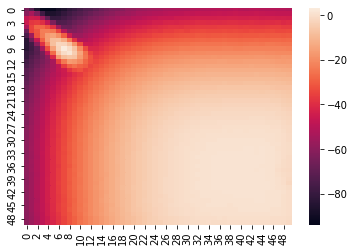

In [96]:
from model.modules.qmix import QMIX

model = QMIX.init_from_save("../../models/rel_overgen/qmix_fo/run10/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

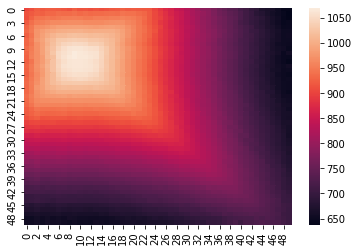

In [97]:
model = QMIX_MANovelD.init_from_save("../../models/rel_overgen/qmix_manoveld_fo/run6/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)

<AxesSubplot:>

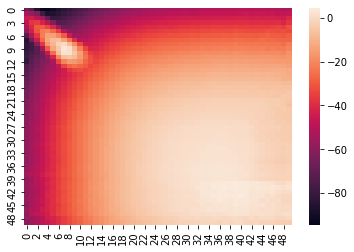

In [98]:
model = QMIX.init_from_save("../../models/rel_overgen/qmix_fo/run5/model.pt")
model.prep_rollouts()
value = get_q_function(model)
sns.heatmap(value)